# **LSTM Chemistry Training Colab**

This Colab serves for training `LSTM_chemistry` models.

The following google drive link corresponds to the most recent project folder(you'll need to ask for access):
https://drive.google.com/drive/folders/1iZtHF_jrLXeIBbAIk5AXBtS-5Ib6sCQ7?usp=sharing

The following cell includes the bare minimum to mount google drive to google colab so that the files can be directly called. The `folder_name` may have to be updated to the latest `Battery_SOH` folder.

In [1]:
from google.colab import drive
import os
import torch as th

# Mounting google drivee
drive.mount('/content/gdrive')
folder_name = 'Battery_SOH_final'
# The root path will change depending on the latest 'bakcup'
root_path = 'gdrive/My Drive/battery_soh/' + folder_name
os.chdir(root_path)
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
device

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


device(type='cuda', index=0)

The cell should output something like:
```
Mounted at /content/gdrive
device(type='cuda', index=0)
```

If the second line says `device(type='cpu')` then you should change your environment options above for GPU for faster results.

In [2]:
# Imports:
# Libraries:
!pip install PyAstronomy
from torch.utils.data import DataLoader, Dataset
from datetime import datetime
import re
import random
import seaborn as sns
sns.set()

# SOH Modules:
# Battery Classes:
from Coin_Classes import *
from MIT_Classes import *
from Nasa_Classes import *
# Models:
from LSTM import *
import LSTM_chemistry as chem #
# Training and Report related:
from Training import *
from Load_Save import *
import DistributionPlots as dp

In [3]:
# Useful definitions:
import main      # Some dictionary definitions such as path_dict

path_dict = main.path_dict

# Batteries to exclude from training and validation datasets:
ignore_dict = {
    'NASA': ['B0049.txt', 'B0050.txt', 'B0051.txt', 'B0052.txt'],
    'MIT': ['B'+str(i).zfill(4)+'.txt' for i in range(15, 48)], 
    # There are no problems with these ^ batteries, it's just that MIT's dataset
    # is huge, so I don't include all of the batteries in the validation dataset
    'Tarascon Coin': ['B0008.txt', 'B0019.txt', 'B0023.txt'],
}

# Batteries to include in the training dataset:
train_dict = {
    'NASA': ['B0006.txt',
             'B0030.txt',
             'B0038.txt',
             'B0039.txt',
             'B0041.txt',
             'B0045.txt',
             'B0055.txt',], # 4ºC
    'MIT': ['B0001.txt'],
    'Tarascon Coin': ['B0001.txt',
                      'B0004.txt',
                      'B0014.txt',
                      'B0016.txt']
}

In [4]:
# [0] # LSTM_v4, DELTA=10 reports:

#NASA
report_name = '2021-08-06 09_22_32.468552-nasav4' ###
# getting the model from the report:
os.chdir('.//Reports/'+report_name)
with open('best_model.txt', 'rb') as f:
    base_model = pickle.load(f)
os.chdir('../../')
nasa_norm = chem.norm_adapt(base_model.norm)
print('nasa_norm', nasa_norm)

#MIT
report_name = '2021-08-04 12_31_41.305058-mitv4'  ###
# getting the model from the report:
os.chdir('.//Reports/'+report_name)
with open('best_model.txt', 'rb') as f:
    base_model = pickle.load(f)
os.chdir('../../')

mit_norm = chem.norm_adapt(base_model.norm)
print('mit_norm', mit_norm)

#COIN
report_name = '2021-08-04 13_33_09.035717-coinv4'  ###
# getting the model from the report:
os.chdir('.//Reports/'+report_name)
with open('best_model.txt', 'rb') as f:
    base_model = pickle.load(f)
os.chdir('../../')
coin_norm = chem.norm_adapt(base_model.norm, tech=1) # tech=1 because Na-ion
print('coin_norm', coin_norm)

nasa_norm (tensor([ 0.4417,  0.4377,  0.4338,  0.4299,  0.4259,  0.4221,  0.4183,  0.4145,
         0.4107,  0.4069,  0.9869,  0.9876,  0.9881,  0.9886,  0.9890,  0.9894,
         0.9898,  0.9901,  0.9905,  0.9908, 20.3975,  0.0000]), tensor([ 0.2395,  0.2398,  0.2400,  0.2402,  0.2404,  0.2406,  0.2408,  0.2410,
         0.2411,  0.2413,  0.0267,  0.0249,  0.0238,  0.0230,  0.0223,  0.0217,
         0.0212,  0.0207,  0.0203,  0.0199, 15.1578,  1.0000]), tensor([0.6211]), tensor([0.1952]), 'zscore')
mit_norm (tensor([ 0.7405,  0.7375,  0.7345,  0.7314,  0.7283,  0.7252,  0.7220,  0.7188,
         0.7155,  0.7123,  0.9729,  0.9732,  0.9736,  0.9739,  0.9743,  0.9747,
         0.9750,  0.9753,  0.9757,  0.9760, 30.0000,  0.0000]), tensor([0.2915, 0.2933, 0.2952, 0.2970, 0.2988, 0.3006, 0.3024, 0.3041, 0.3058,
        0.3075, 0.0208, 0.0207, 0.0206, 0.0205, 0.0205, 0.0204, 0.0203, 0.0203,
        0.0202, 0.0201, 1.0000, 1.0000]), tensor([0.9173]), tensor([0.0424]), 'zscore')
coin_norm (te

In [5]:
# initializing dataset related variables:
fixed_len = 150         ## Recommended values
batch_size = 1          ##
adimensionalize=True    ##
norm_type = 'zscore'    ##
DELTA = 10              ###

cycle_lim = 1e6         ### depends on your analysis
LSTM_version = 4        ###

In [6]:
# Emptying dataset lists
Train_list = []
Valid_list = []

 **NOTE: LSTM CHEMISTRY**

The following datasets and models are called from the `LSTM_chemistry` module
(`chem.`). If you want to try mixing datasets for regular `LSTM` or `LSTM_with_norm`, you'll have to change some things.

---

**How to mix datasets**

In the next cell (`[1]`), pick a `dataset_name`, a `norm` dictionary and a `time_step` dictionary (optional).

By running the cell immediately after (`[2]`), batteries in `train_dict[dataset_name]` will be added to the `Train_list`, and the rest to `Valid_list`.

You can then change the `dataset_name`, `time_step` and `norm` (in `[1]`) and rerun the following cell (`[2]`). This way, batteries from this other dataset will be added to the dataset lists.

When you're finished, run cell `[3]`, which will merge the datasets together accordingly and create a loader for each one.

---

**About normalisation and time step**

**Notice that, because normalisation is different for each dataset, normalisation information _isn't easily accessible_ if you don't save it.**
Also, if you leave `norm = None`, each battery will be normalised separately (with respect to itself - even for batteries from the same dataset), **same goes for the `time_step` used**. Recommended `time_step` values are given by default.
It is recommended to get normalisation information for each dataset from reports (see cell `[0]`, three cells up^). The default values won't work for all LSTM types and delta values.

If you need to check the normalisation used for each case, you can use something like this:

```
for dataset in Train_list:
    print(dataset.dataset_name)  # A string indicating the dataset (NASA, ...)
    print(dataset.batteries)     # The batteries used in this dataset (just one)
    print(dataset.norm)          # The normalisation info used/calculated
    print(dataset.time_step)     # The time step used/calculated
```




In [7]:
# [1]

### the variables called here were defined with the other dictionaries^
norm = {'NASA': nasa_norm, 'MIT': mit_norm, 'Tarascon Coin': coin_norm}                      

### recommended: {NASA: 30, MIT: 3, Tarascon Coin: 30}
time_step = main.default_time_step_dict # defined in main.py

In [9]:
# [2]
dataset_name = 'Tarascon Coin'      ### NASA; MIT; Tarascon Coin.

# Dataset creation:
try:
    os.chdir(path_dict[dataset_name])
except FileNotFoundError:
    raise FileNotFoundError("Current directory: "+os.getcwd())

files = os.listdir()    # All files in the folder
file_list = []          # List with the valid files

for file_name in files:
    match = re.search(r'B\d{4}.txt', file_name) # Only take into acount
                                                # the battery files
    if match == None:
        continue
    else:
        file_list.append(file_name)
file_list.sort()

ignore = ignore_dict[dataset_name]
train = train_dict[dataset_name]

# Training files:
for file_name in file_list:
    if file_name not in train:
        continue
    else:
        with open(file_name, 'rb') as f:
            Battery = pickle.load(f)

        # Here, Train_list is a list of datasets.
        Train_list.append(
            chem.Torch_Dataset_LSTM(
                [Battery], DELTA, LSTM_version, print_bool=True, 
                time_step=time_step[dataset_name], fixed_len=fixed_len,
                norm_type=norm_type, norm=norm[dataset_name], 
                adimensionalize=adimensionalize
            )
        )

# Validation files:
for file_name in file_list:
    if (file_name not in train) and (file_name not in ignore):
        with open(file_name, 'rb') as f:
            Battery = pickle.load(f)
        
        # Here, Valid_list is a list of datasets.
        Valid_list.append(
            chem.Torch_Dataset_LSTM(
                [Battery], DELTA, LSTM_version, print_bool=True, 
                time_step=time_step[dataset_name], fixed_len=fixed_len,
                norm_type=norm_type, norm=norm[dataset_name], 
                adimensionalize=adimensionalize
                )
            )

os.chdir('../../../../')

B0001
B0001
303
B0004
B0004
47
B0014
52
B0016
B0016
85
B0002
B0002
77
B0003
B0003
64
B0005
83
B0006
B0006
72
B0009
30
B0010
B0010
52
B0011
30
B0012
B0012
5
B0013
34
B0015
B0015
62
B0017
B0017
110
B0018
55
B0020
15
B0021
23
B0022
20
B0024
17


In [11]:
# [3]
# Merging datasets:
train_dataset = chem.Torch_Dataset_Mixer(Train_list)
valid_dataset = chem.Torch_Dataset_Mixer(Valid_list)

# Loaders:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)
sim_train_loader = DataLoader(dataset=train_dataset, 
                              batch_size=len(train_dataset), shuffle=False)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=len(valid_dataset),
                          shuffle=False)

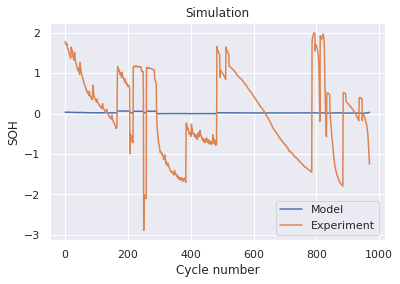

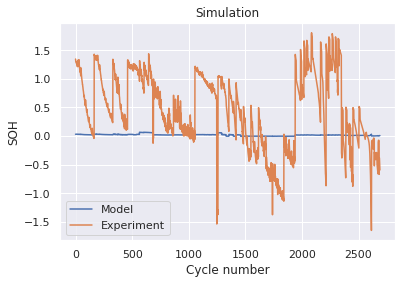

In [12]:
# Model information:
HIDDEN_DIM = 50             ##
DROPOUT = 0                 ##
pool_type = 'bi_mean'       ##

# Defining the model
Model = chem.LSTM_v4(
    DELTA, HIDDEN_DIM, pooling_layer=pool_type, drop_out=DROPOUT,
    version = LSTM_version, norm=None, lin_layers=2, lin_dropout=0.5
    # train_dataset has no attribute "norm"
    )

Model = Model.to(device)

# Model's performance as is (should be bad) (useful for seeing the datasets)
simulate(sim_train_loader, Model, device=device, denormalize=False, fixed_lims=False)
simulate(valid_loader, Model, device=device, denormalize=False, fixed_lims=False)
# denormalize=False is necessary. train_dataset doesn't have information on
# normalisation because it's different for each dataset

1 . Training loss:  tensor(0.9574)
1 . Validation loss:  tensor(0.6102)
2 . Training loss:  tensor(0.9533)
2 . Validation loss:  tensor(0.5989)
3 . Training loss:  tensor(0.9364)
3 . Validation loss:  tensor(0.5819)
4 . Training loss:  tensor(0.9183)
4 . Validation loss:  tensor(0.5563)
5 . Training loss:  tensor(0.9014)
5 . Validation loss:  tensor(0.5242)
6 . Training loss:  tensor(0.8745)
6 . Validation loss:  tensor(0.4881)
7 . Training loss:  tensor(0.8462)
7 . Validation loss:  tensor(0.4479)
8 . Training loss:  tensor(0.8156)
8 . Validation loss:  tensor(0.4083)
9 . Training loss:  tensor(0.7918)
9 . Validation loss:  tensor(0.3697)
10 . Training loss:  tensor(0.7675)
10 . Validation loss:  tensor(0.3344)
11 . Training loss:  tensor(0.7458)
11 . Validation loss:  tensor(0.3041)
12 . Training loss:  tensor(0.7227)
12 . Validation loss:  tensor(0.2767)
13 . Training loss:  tensor(0.7082)
13 . Validation loss:  tensor(0.2547)
14 . Training loss:  tensor(0.6866)
14 . Validation loss

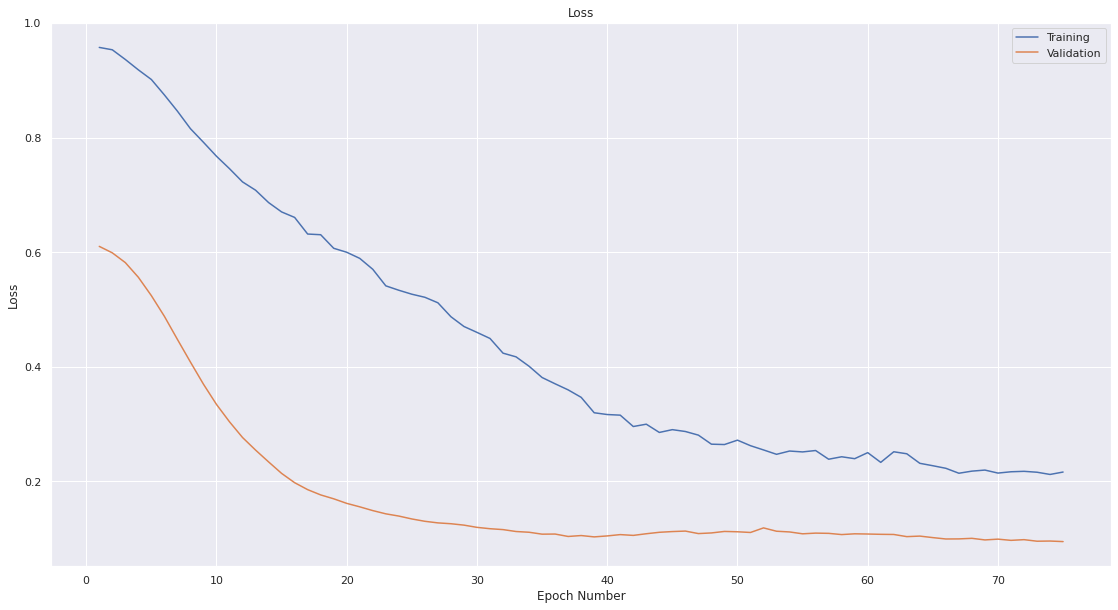

Best validation error:  75


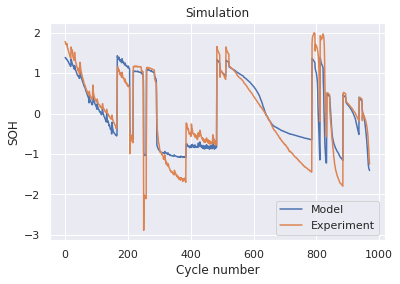

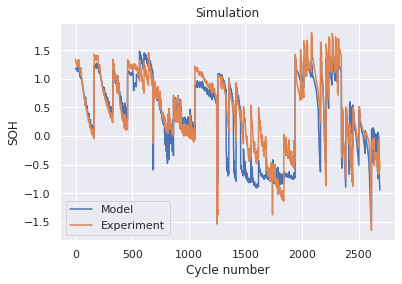

In [13]:
# Training Loop:
Nb_Epochs = 75              ###
Learning_Rate = 5e-6        ###


Train_info, _, _, date = Train(
    train_loader, valid_loader, Model, Nb_Epochs, plot_bool=True,
    LR=Learning_Rate, report=True, print_bool=True, device=device,
    remove_bool=True
    )

# Best epoch's performance:
simulate(sim_train_loader, Model, denormalize=False, device=device, fixed_lims=False)
simulate(valid_loader, Model, denormalize=False, device=device, fixed_lims=False)

In [14]:
# Calculating the model's error for each battery for each dataset:
# You'll have to define time_step and norm for each dataset


for name in ['NASA', 'MIT', 'Tarascon Coin']:
    Load_Save_v2(
        date, name, device=device, time_step=time_step[name],
        norm_test=norm[name], denormalize_bool=True
        )

B0005
165
B0006
166
B0007
165
B0018
130
B0025
27
B0026
24
B0027
27
B0028
27
B0029
40
B0030
40
B0031
40
B0032
40
B0033
181
B0034
189
B0036
193
B0038
44
B0039
42
B0040
43
B0041
25
B0042
64
B0043
64
B0044
65
B0045
68
B0046
66
B0047
67
B0048
68
B0053
55
B0054
101
B0055
98
B0000
280
B0001
130
B0002
426
B0003
313
B0004
427
B0005
465
B0006
457
B0007
522
B0008
829
B0009
951
B0010
534
B0011
461
B0012
432
B0013
460
B0014
471
B0015
126
B0016
382
B0017
477
B0018
466
B0019
443
B0020
487
B0021
475
B0022
501
B0023
509
B0024
205
B0025
152
B0026
186
B0027
454
B0028
494
B0029
483
B0030
465
B0031
477
B0032
506
B0033
507
B0034
485
B0035
449
B0036
524
B0037
468
B0038
455
B0039
449
B0040
479
B0041
416
B0042
450
B0043
447
B0044
444
B0045
470
B0046
420
B0047
676
B0001
B0001
303
B0002
B0002
77
B0003
B0003
64
B0004
B0004
47
B0005
83
B0006
B0006
72
B0009
30
B0010
B0010
52
B0011
30
B0012
B0012
5
B0013
34
B0014
52
B0015
B0015
62
B0016
B0016
85
B0017
B0017
110
B0018
55
B0020
15
B0021
23
B0022
20
B0024
17
